# Plenty of packages to install

In [116]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as ss
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
from scipy import stats
import numpy as np
import seaborn as sns

## We load the train csv and drop the outliers as discussed and as shown by scatterplots of totalbsmtsf and grlivarea against saleprice

In [117]:
#dropping SalePrice column for now while we process predictors
rawdf = pd.read_csv('train.csv')
rawdf2 = rawdf.drop(rawdf[rawdf['TotalBsmtSF'] > 6000].index).reset_index(drop=True)
rawdf3 = rawdf2.drop(rawdf2[rawdf2['GrLivArea'] > 4600].index).reset_index(drop=True)
prices = rawdf3['SalePrice']
raw_features = rawdf3.drop(["SalePrice"], axis=1).reset_index(drop=True)

## We set up my DummyMake function to make dummies of categorical columns and drop the original

In [3]:
#Setting the rules for our OHE
#setting up a dummy maker function
Dummymaker = OneHotEncoder( categories = 'auto', drop='first', sparse = False )
def DummyMake(dfx, colname):
    df = dfx.copy()
    Dums = Dummymaker.fit_transform(df[[colname]])
    Dums = pd.DataFrame(Dums, columns=Dummymaker.get_feature_names([colname]))
    df = pd.concat( (df.drop([colname], axis=1).reset_index(drop = True), Dums), axis = 1 )
    return df

## I made 4 missing value imputers, one that fills with 0, one that fills with the word "none", one that fills with the most frequent value in a column, and one that fills with the mean of the column

In [4]:
#Setting up some of the imputers we'll use for missing values, one that replaces them with 0 (numerical features)
#and ones that replaces them with the most common value (categorical features)
imp0 = SimpleImputer(strategy='constant', fill_value = 0)
impNone = SimpleImputer(strategy = 'constant', fill_value = 'none')
impTyp = SimpleImputer(strategy = 'most_frequent')
impMean = SimpleImputer(strategy = 'mean')

### The following functions are defined to transform our features as needed, either by dummifying them, imputing them, setting them up as a boolean (typical vs atypical) or some combination of these

In [6]:
def TotalBsmtSFImpute(dfx):
    df = dfx.copy()
    df['TotalBsmtSF'] = imp0.fit_transform(df[['TotalBsmtSF']])
    return df  

In [7]:
def LotShapeBool(dfx):
    df = dfx.copy()
    df['LotShape'] = df['LotShape'].apply(lambda x: 1 if x == 'Reg' else 0 )
    return df

In [8]:
def HouseStyleBool(dfx):
    df = dfx.copy()
    df['HouseStyle'] = df['HouseStyle'].apply(lambda x: 1 if x == '2Story' else 0 )
    return df

In [9]:
def FoundationDums(dfx):
    return DummyMake(dfx, 'Foundation')

In [10]:
def BsmtExposureBool(dfx):
    df = dfx.copy()
    df['BsmtExposure'] = impTyp.fit_transform(df[['BsmtExposure']])
    df['BsmtExposure'] = df['BsmtExposure'].apply(lambda x: 0 if x == 'No' else 1 )
    return df

In [11]:
def TotalBsmtSFImpute(dfx):
    df = dfx.copy()
    df['TotalBsmtSF'] = imp0.fit_transform(df[['TotalBsmtSF']])
    return df

In [12]:
def HeatingQCBool(dfx):
    df = dfx.copy()
    df['HeatingQC'] = df['HeatingQC'].apply(lambda x: 1 if x == 'Ex' else 0)
    return df

In [13]:
def CentralAirBool(dfx):
    df = dfx.copy()
    df['CentralAir'] = df['CentralAir'].apply(lambda x: 1 if x == 'Y' else 0 )
    return df

In [14]:
def KitchenQualDums(dfx):
    df = dfx.copy()
    df['KitchenQual'] = impTyp.fit_transform(df[['KitchenQual']])
    return DummyMake(df, 'KitchenQual')

In [137]:
def KitchenQualBool(dfx):
    df = dfx.copy()
    df['KitchenQual'] = df['KitchenQual'].apply(lambda x: 1 if x == 'Ex' else 0)
    return df

In [15]:
def FireplacesBool(dfx):
    df = dfx.copy()
    df['Fireplaces'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0 )
    return df

In [16]:
def GarageCarsImpute(dfx):
    df = dfx.copy()
    df['GarageCars'] = imp0.fit_transform(df[['GarageCars']])
    return df

### Bathrooms features

In [185]:
def BathroomsCalc(dfx):
    df = dfx.copy()
    df['BsmtFullBath'] = imp0.fit_transform(df[['BsmtFullBath']])
    df['Bathrooms'] = df['BsmtFullBath'] + df['FullBath'] + (0.5 * df['HalfBath'])
    return df

### Before/After real estate crisis:

In [18]:
def AfterCrisis(row):
    if row['YrSold'] > 2007 :
        return 1
    return 0

### Here I define my ordinal "location" column to replace neighborhood entirely, depending on which neighborhood the house is in it will be scored 1-4 (based on where that neighborhood's mean sales price falls in the quartile ranges)

In [19]:
def LocationCalc(row):
    if row['Neighborhood'] in loc1 :
        return 1
    elif row['Neighborhood'] in loc2 :
        return 2
    elif row['Neighborhood'] in loc3 :
        return 3
    return 4

In [20]:
loc1 = ['BrDale', 'BrkSide', 'Edwards', 'IDOTRR', 'MeadowV', 'OldTown']
loc2 = ['Blueste', 'Mitchel', 'NAmes', 'NPkVill', 'SWISU', 'Sawyer']
loc3 = ['Blmngtn', 'CollgCr',  'Gilbert', 'NWAmes', 'SawyerW', 'Crawfor', 'ClearCr']
loc4 = ['NoRidge', 'NridgHt', 'Somerst', 'StoneBr', 'Timber', 'Veenker']

In [21]:
def DropCols(dfx):
    df = dfx.copy()
    for col in dropcols:
        df = df.drop([col], axis=1).reset_index(drop = True)
    return df

In [22]:
def SSfeatures(dfx):
    ss = StandardScaler()
    df = dfx.copy()
    return pd.DataFrame(ss.fit_transform( df ), columns = df.columns)

## Columns that will be dropped at the end of processing

In [187]:
dropcols = ['YrSold', 'Neighborhood', 'WoodDeckSF', 'OpenPorchSF', 'ExterQual', 'YearBuilt', 'GarageType', 'Exterior1st', 'BsmtQual', 'RoofStyle', 'MSZoning', 'MasVnrType', 'Condition1', 'BldgType', 'BedroomAbvGr', 'TotRmsAbvGrd', 'GrLivArea', 'TotalBsmtSF', 'MSSubClass', 'MasVnrArea', 'Id', 'Street', 'Alley', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Condition2', 'YearRemodAdd', 'RoofMatl', 'Exterior2nd', 'ExterCond', 'BsmtCond', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'Heating', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'KitchenAbvGr', 'Functional', 'FireplaceQu', 'GarageYrBlt', 'GarageFinish', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'SaleType', 'SaleCondition', 'FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath']

## Full Preprocess column which calls each of the above defined columns and sets up some additional engineered features (TotalSF, HouseAge, PorchSF), as well as the imputation of missing LotFrontage values by imputing the mean LotFrontage in the house's respective neighborhood.

In [188]:
def TABSPreProcess(dfx):
    df = dfx.copy()
    df['TotalSF'] = df['GrLivArea'] + df['TotalBsmtSF']
    df["LotFrontage"] = df.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.mean()))
    df['HouseAge'] = df['YrSold'] - df['YearBuilt']
    df['AfterCrisis'] = df.apply(lambda row: AfterCrisis(row), axis = 1)
    df['Location'] = df.apply(lambda row: LocationCalc(row), axis = 1)
    df = LotShapeBool(df)
    df = HouseStyleBool(df)
    df = FoundationDums(df)
    df = BsmtExposureBool(df)
    df = TotalBsmtSFImpute(df)
    df['TotalSF'] = df['GrLivArea'] + df['TotalBsmtSF']
    df['PorchSF'] = df['WoodDeckSF'] + df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']
    df = HeatingQCBool(df)
    df = CentralAirBool(df)
    df = KitchenQualBool(df)
    df = FireplacesBool(df)
    df = GarageCarsImpute(df)
    df = BathroomsCalc(df)
    df = DropCols(df)
    df = SSfeatures(df)
    return df  

In [189]:
processed_features = TABSPreProcess(raw_features)

In [190]:
processed_df = processed_features.copy()

## Sticks on the log of the price (for normal distribution)

In [191]:
processed_df['SalePrice'] = rawdf3['SalePrice'].apply(lambda x: math.log(x))

## Check correlation of featured engineers with price

In [192]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
(processed_df.corr()['SalePrice'][:]).sort_values(ascending = False)

SalePrice            1.000000
OverallQual          0.821404
TotalSF              0.820738
Location             0.721001
GarageCars           0.681033
Bathrooms            0.670998
Foundation_PConc     0.531193
Fireplaces           0.510253
HeatingQC            0.466925
KitchenQual          0.417469
PorchSF              0.399695
LotFrontage          0.369760
CentralAir           0.351598
BsmtExposure         0.306401
HouseStyle           0.263305
LotArea              0.260544
Foundation_Wood      0.008917
Foundation_Stone    -0.014616
OverallCond         -0.036821
AfterCrisis         -0.041889
Foundation_Slab     -0.158984
LotShape            -0.289847
Foundation_CBlock   -0.337909
HouseAge            -0.587767
Name: SalePrice, dtype: float64

In [193]:
X = processed_features
y = processed_df['SalePrice']

### Define and fit LinearRegression

In [194]:
lm = LinearRegression()

In [195]:
lm.fit(processed_features, processed_df['SalePrice'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [196]:
print(lm.score(processed_features, processed_df['SalePrice']))
preds = pd.DataFrame(lm.predict(processed_features))
round(mean_squared_error(preds[0].apply(lambda x: math.exp(x)), rawdf3['SalePrice'])**.5)

0.9059882477615485


22768.0

## Train-test-split setup for cross validation with OLS, Lasso, and Ridge Models. We test each model, and take their respective coefficients to plot at the end

In [161]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, train_size = 0.8, random_state = 1, stratify = X['CentralAir'] )

In [162]:
ols = LinearRegression()
ols.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [163]:
ols = LinearRegression()
ols.fit(xtrain, ytrain)
cvs = cross_val_score(ols, xtrain, ytrain, cv = 5)


print('Training Score:', ols.score(xtrain, ytrain))
print('Cross Validation Score:', cvs, 'Mean:', cvs.mean())
print('Test Score:', ols.score(xtest, ytest))



Training Score: 0.9057662526255296
Cross Validation Score: [0.89790787 0.86682909 0.92505898 0.90878486 0.90001812] Mean: 0.8997197846527923
Test Score: 0.906940392600286


In [164]:
olsco = pd.DataFrame(ols.coef_)
olsco = olsco.rename(columns = {0: 'OLS'})

In [165]:
features = pd.DataFrame(X.columns)
features = features.rename(columns = {0: 'Feature'})

In [166]:
RidgeTest = RidgeCV(alphas=np.logspace(-4, 4, 10), cv = 5)
RidgeTest.fit(xtrain, ytrain)
print('Best Alpha:', RidgeTest.alpha_)
print('Training Score:', RidgeTest.score(xtrain, ytrain))
print('Test Score:', RidgeTest.score(xtest, ytest))

Best Alpha: 21.54434690031882
Training Score: 0.9056678289425396
Test Score: 0.9071360393567133


In [167]:
ridgeco = pd.DataFrame(RidgeTest.coef_)
ridgeco = ridgeco.rename(columns = {0: 'Ridge'})

In [168]:
LassoTest = LassoCV(alphas=np.logspace(-4, 4, 10), cv = 5)
LassoTest.fit(xtrain, ytrain)
print('Best Alpha:', LassoTest.alpha_)
print('Training Score:', LassoTest.score(xtrain,ytrain))
print('Test Score:', LassoTest.score(xtest, ytest))

Best Alpha: 0.000774263682681127
Training Score: 0.9057164107553912
Test Score: 0.9074308222713346


In [169]:
lassoco = pd.DataFrame(LassoTest.coef_)
lassoco = lassoco.rename(columns = {0: 'Lasso'})

In [170]:
coeffs = pd.concat((features, olsco, ridgeco, lassoco), axis=1)

## This plots our coefficients for each predictor given each model, the relative stability is why we can be comfortable sticking with OLS for a highly interpretable model

[Text(0, 0, 'LotFrontage'),
 Text(0, 0, 'LotArea'),
 Text(0, 0, 'LotShape'),
 Text(0, 0, 'HouseStyle'),
 Text(0, 0, 'OverallQual'),
 Text(0, 0, 'OverallCond'),
 Text(0, 0, 'BsmtExposure'),
 Text(0, 0, 'HeatingQC'),
 Text(0, 0, 'CentralAir'),
 Text(0, 0, 'KitchenQual'),
 Text(0, 0, 'Fireplaces'),
 Text(0, 0, 'GarageCars'),
 Text(0, 0, 'TotalSF'),
 Text(0, 0, 'HouseAge'),
 Text(0, 0, 'AfterCrisis'),
 Text(0, 0, 'Location'),
 Text(0, 0, 'Foundation_CBlock'),
 Text(0, 0, 'Foundation_PConc'),
 Text(0, 0, 'Foundation_Slab'),
 Text(0, 0, 'Foundation_Stone'),
 Text(0, 0, 'Foundation_Wood'),
 Text(0, 0, 'PorchSF'),
 Text(0, 0, 'Bathrooms')]

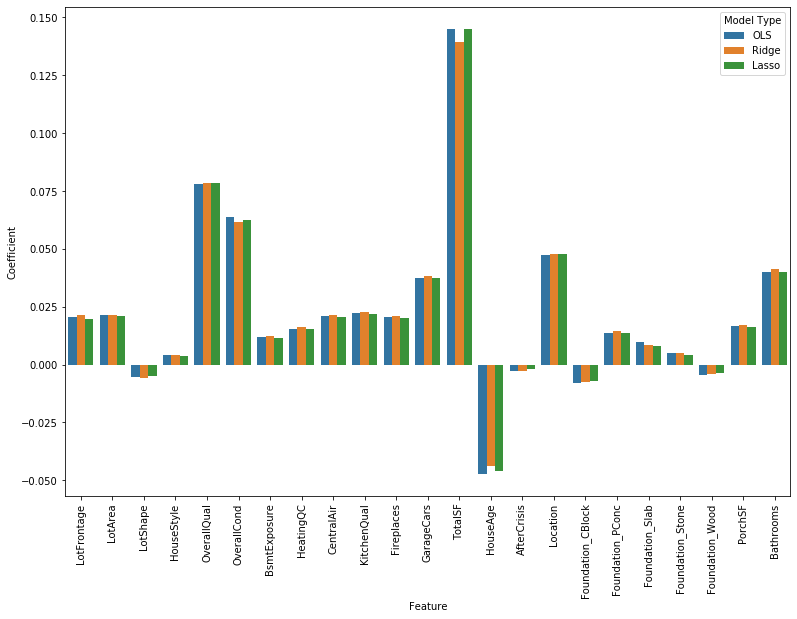

In [171]:
bardata = coeffs.melt('Feature', var_name='Model Type', value_name='Coefficient')
plt.subplots(figsize=(13, 9))
ax=sns.barplot(x='Feature', y='Coefficient', hue='Model Type', data=bardata)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

## R-like description of our model, if you'd like to check it out

In [197]:
X2 = sm.add_constant(processed_features)
est = sm.OLS(processed_df['SalePrice'], X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     600.8
Date:                Fri, 28 Feb 2020   Prob (F-statistic):               0.00
Time:                        13:28:38   Log-Likelihood:                 992.28
No. Observations:                1458   AIC:                            -1937.
Df Residuals:                    1434   BIC:                            -1810.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                12.0240      0.00

/Users/tommymanna/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


## Here finally we load the test dataset and preprocess it as above, we use our fit model to predict log prices and take the exponent to convert them back to dollars. We format the predictions as needed as save to a CSV.

In [ ]:
rawdf = pd.read_csv('test.csv')
raw_features = rawdf.copy()
processed_features = TABSPreProcess(raw_features)
processed_df = processed_features.copy()

In [176]:
predictions = lm.predict(processed_df)

In [177]:
predictions = pd.DataFrame(predictions)

In [178]:
predictions[0] = predictions[0].apply(lambda x: math.exp(x))

In [179]:
predictions = pd.concat((rawdf['Id'], predictions), axis = 1)

In [180]:
predictions = predictions.rename(columns = {0: 'SalePrice'})

In [181]:
predictions.head(20)

,Id,SalePrice
0,1461,116998.133215
1,1462,157517.341310
2,1463,175882.665809
3,1464,203290.247308
4,1465,193534.888051
5,1466,177668.065460
6,1467,198368.341292
7,1468,167787.719788
8,1469,199038.280886
9,1470,113250.393982


In [182]:
predictions['Id'] = predictions['Id'].astype(int)

In [183]:
predictions.to_csv('predictions.csv', index = False)